<a href="https://www.kaggle.com/code/aleksandrmorozov123/gpt-architecture?scriptVersionId=254700648" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/14-million-word-corpus-txt/corpus.txt
/kaggle/input/harry-potter-books/03 Harry Potter and the Prisoner of Azkaban.txt
/kaggle/input/harry-potter-books/06 Harry Potter and the Half-Blood Prince.txt
/kaggle/input/harry-potter-books/05 Harry Potter and the Order of the Phoenix.txt
/kaggle/input/harry-potter-books/02 Harry Potter and the Chamber of Secrets.txt
/kaggle/input/harry-potter-books/07 Harry Potter and the Deathly Hallows.txt
/kaggle/input/harry-potter-books/01 Harry Potter and the Sorcerers Stone.txt
/kaggle/input/harry-potter-books/04 Harry Potter and the Goblet of Fire.txt


**In this notebook I will create GPT (Generative Pretrained Transformer) small model and training this later**

## Part 1. Configuration and Dummy model  <a class="anchor"  id="chapter1"></a>

In [2]:
from importlib.metadata import version

print("matplolib version: ", version("matplotlib"))
print("torch version: ", version("torch"))
print("tiktoken version: ", version("tiktoken"))

matplolib version:  3.7.5
torch version:  2.5.1+cu124
tiktoken version:  0.9.0


In [3]:
# configuration of the GPT model
GPT_CONFIG_124M = {
    "vocab_size": 50257,     # vocabulary size
    "context_length": 1024,  # context length
    "emb_dim": 768,          # embedding dimensions
    "n_heads": 12,           # number of attention heads
    "n_layers": 12,          # number of layers
    "drop_rate": 0.1,        # dropout rate
    "qkv_bias": False        # Query-Key-Value bias
}

In [4]:
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        # use a placeholder for Transformer Block
        self.trf_blocks = nn.Sequential(*[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        # use a placeholder for Layer Norm
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()

    def forward(self, x):
        return x 

class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()

    def forward(self, x):
        return x

In [5]:
# encoding process
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
batch = []

txt1 = "If you grind and "
txt2 = "You wake every day and"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[ 1532,   345, 20078,   290,   220],
        [ 1639,  7765,   790,  1110,   290]])


In [6]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)

logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 5, 50257])
tensor([[[-0.4086,  1.0408, -0.5351,  ..., -1.6850, -0.2098,  0.3704],
         [-0.1377,  1.9332, -0.4630,  ..., -0.4409, -0.0980,  0.0817],
         [ 0.2650, -0.0898, -0.0479,  ...,  0.4372,  0.3871,  0.2004],
         [-0.5968,  0.7088,  1.3957,  ...,  0.4451,  1.5210,  0.8915],
         [-0.7740, -0.9768,  1.2553,  ...,  0.7457, -0.4746,  0.2609]],

        [[-0.1776,  0.6227, -0.0074,  ..., -1.2598, -0.6497,  0.8217],
         [-0.6403,  1.4392, -1.2086,  ...,  0.9956,  1.0368,  2.2615],
         [-0.2581, -0.2354, -0.3046,  ..., -0.9638,  0.7429, -0.2973],
         [-0.0722,  0.5075,  0.0342,  ...,  1.2990,  0.3487,  0.2775],
         [-1.0624, -0.9751,  2.0261,  ..., -1.3601,  0.3677,  0.0639]]],
       grad_fn=<UnsafeViewBackward0>)


In [7]:
# layer normalization
torch.manual_seed(123)

# create 2 training examples with 5 dimensions (features) each
batch_example = torch.randn(2, 5) 

layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [8]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [9]:
out_norm = (out - mean) / torch.sqrt(var)
print("Normalized layer outputs:\n", out_norm)

mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[9.9341e-09],
        [1.9868e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [10]:
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [11]:
# implement a Layer normalization class
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift
        

In [12]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)

In [13]:
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


  ## Part 2. Feed forward network with GELU (Gaussian Error Linear Unit) activations  <a class="anchor"  id="chapter2"></a>


We have approximation of this activation function
$$ GELU(x) \approx 0.5 \cdot x \cdot (1 + \tanh[\sqrt{\frac{2}{\pi}} \cdot (x + 0.044715 \cdot x^3)])  $$

In [14]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow (x, 3))
        ))

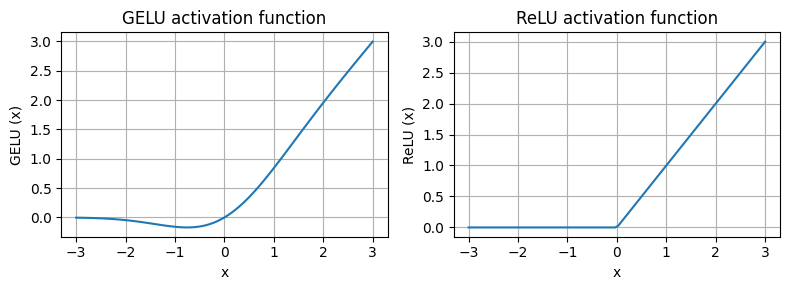

In [15]:
# visualize GELU and ReLU
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label} (x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

In [16]:
# FeedForward neural network module
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )
    def forward(self, x):
        return self.layers(x)

In [17]:
ffn = FeedForward(GPT_CONFIG_124M)

# input shape: [batch_size, num_token, emb_size]
x = torch.rand(2, 3, 768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


## Part 2.1 Creating the Dataloader <a class="anchor"  id="subsection2"></a>

In [18]:
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True, num_workers=0):
    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

    return dataloader

## Part 2.2 Multi-head attention module <a class="anchor"  id="subsection2"></a>

In [19]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads 

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)
        attn_scores = queries @ keys.transpose(2, 3)
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)
        context_vec = (attn_weights @ values).transpose(1, 2)
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)
        return context_vec

## Part 2.3 Residual connections <a class="anchor"  id="subsection2"></a>

In [20]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x)
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                return x

    def print_gradients(model, x):
        output = model(x)
        target = torch.tensor([[0.]])
        loss = nn.MSELoss()
        loss = loss(output, target)
        loss.bakward()
        for name, param in model.named_parameters():
            if "weight" in name:
                print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")        

## Part 3. Creating transformer block with layer normalization, GELU activation, FFN and residual connections (Gaussian Error Linear Unit) activations  <a class="anchor"  id="chapter3"></a>

In [21]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in = cfg["emb_dim"],
            d_out = cfg["emb_dim"],
            context_length = cfg["n_heads"],
            num_heads = cfg["n_heads"],
            dropout = cfg["drop_rate"],
            qkv_bias = cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        return x

In [22]:
torch.manual_seed(123)

x = torch.rand(2, 4, 768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


## Part 4. Creating the GPT model with all blocks  <a class="anchor"  id="chapter4"></a>

In [23]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [24]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[ 1532,   345, 20078,   290,   220],
        [ 1639,  7765,   790,  1110,   290]])

Output shape: torch.Size([2, 5, 50257])
tensor([[[ 0.1985, -0.4526,  0.0454,  ...,  0.8520,  0.3040, -1.0066],
         [ 0.2341, -0.3687, -0.7418,  ...,  0.0821,  0.4494, -0.0461],
         [ 1.3894,  0.2347, -0.3581,  ...,  0.5575, -0.5546, -0.4210],
         [-0.2292,  0.0089,  0.0307,  ...,  0.9142, -0.4753, -0.3163],
         [ 1.1916,  0.0446,  0.0527,  ..., -0.3849, -0.0461,  0.1062]],

        [[-0.2016,  0.4053,  0.0196,  ..., -0.0396,  0.3018, -0.0715],
         [ 0.1554,  0.4683, -0.3368,  ..., -0.8829, -0.0151,  0.6384],
         [ 0.8960,  0.4588,  0.5745,  ..., -0.2185, -0.6139,  0.7694],
         [-0.9204, -0.0439,  0.2790,  ...,  1.3708, -0.6990,  0.5013],
         [ 0.0596,  0.5930,  0.6373,  ..., -0.1750, -0.3984, -0.5319]]],
       grad_fn=<UnsafeViewBackward0>)


## Part 5. Generating text with the model  <a class="anchor"  id="chapter5"></a>

In [25]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        probas = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

In [26]:
# input example
start_context = "Good morning, this day is"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [10248, 3329, 11, 428, 1110, 318]
encoded_tensor.shape: torch.Size([1, 6])


In [27]:
model.eval()
out = generate_text_simple(model=model,
                          idx=encoded_tensor,
                          max_new_tokens=6,
                          context_size=GPT_CONFIG_124M["context_length"])

print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[10248,  3329,    11,   428,  1110,   318, 16640, 18445, 12501,  8623,
         49214, 39617]])
Output length: 12


In [28]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Good morning, this day is Mackrikesdeconder Uriel Emails


## Part 6. Training and validation losses  <a class="anchor"  id="chapter6"></a>

In [29]:
# renewed configuration
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # vocabulary size
    "context_length": 256, # shortened context length from 256
    "emb_dim": 768,        # embedding dimension
    "n_heads": 12,         # number of attention heads
    "n_layers": 12,        # number of layers
    "drop_rate": 0.1,      # dropout rate
    "qkv_bias": False      # query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [30]:
# loading the data
file_path = '/kaggle/input/harry-potter-books/01 Harry Potter and the Sorcerers Stone.txt'

with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

In [31]:
# first 200 characters
print(text_data[:199])

M r. and Mrs. Dursley, of number four, Privet Drive, were proud to say that they were perfectly normal, thank you very much. They were the last people you’d expect to be involved in anything strange 


In [32]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 439478
Tokens: 124336


In [33]:
# train and validation ratio - we get standard 90/10
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0,
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0,
)

In [34]:
# sanity check
if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
         "Try to lower the `GPT_CONFIG_124M['context_length']` or "
         "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
         "Try to lower the `GPT_CONFIG_124M['context_length']` or "
         "decrease the `training_ratio`")

In [35]:
# check training and validation ratio
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 111616
Validation tokens: 12544
All tokens: 124160


In [36]:
# utility function for calculating cross-entropy loss of a given batch
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # reduce the number of batches to match the total number of batches in the dala loader
        # if num_bathces exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

def evaluate_model(model, train_loader,val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, devoce, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [37]:
# training the model
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids=generate_text_simple(
            model=model, idx=encoded, max_new_tokens=50,
            context_size=context_size
        )
        decoded_text = token_ids_to_text(token_ids, tokenizer)
        print(decoded_text.replace("\n", " "))
    model.train()

def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                      eval_freq, eval_iter, start_context, tokenizer):
    # initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen = 0
    global_step = -1

    # main training loop
    for epoch in range(num_epochs):
        model.train()
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1
            
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                     f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}"
                )
        # print a sample text after each epoch
        generate_and_print_sample(model, tokenizer, device, start_context)

    return train_losses, val_losses, track_tokens_seen

## Part 7. Llama 2 architecture  <a class="anchor"  id="chapter7"></a>

In [38]:
from importlib.metadata import version

pkgs = [
    "huggingface_hub",  # to download pretrained weights
    "sentencepiece",    # to implement the tokenizer
    "torch",            # to implement the model
]
for p in pkgs:
    print(f"{p} version: {version(p)}")

huggingface_hub version: 0.30.2
sentencepiece version: 0.2.0
torch version: 2.5.1+cu124


**In Llama we have RMSNorm layer (Root Mean Square Layer Normalization**
$$ y_i = \frac{x_i}{RMS(x)}\gamma_i $$
where 
$$ RMS(x) = \sqrt{\epsilon +\frac{1}{n} \sum x_i^2} $$

In [39]:
class RMSNorm(nn.Module):
    def __init__(self, emb_dim, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.emb_dim = emb_dim
        self.weight = nn.Parameter(torch.ones(emb_dim)).float()
    
    def forward(self, x):
        means = x.pow(2).mean(dim=-1, keepdim=True)
        x_normed = x * torch.rsqrt(means + self.eps)
        return (x_normed * self.weight).to(dtype=x.dtype)

In [40]:
# check the RMSNorm
torch.manual_seed(123)

example_batch = torch.randn(2, 3, 4)

rms_norm = RMSNorm(emb_dim=example_batch.shape[-1])
rmsnorm_pytorch = torch.nn.RMSNorm(example_batch.shape[-1], eps=1e-5)
assert torch.allclose(rms_norm(example_batch), rmsnorm_pytorch(example_batch))

**Replacing GELU with SiLU activation (Sigmoid-Weighted Linear Unit)**
$$ silu(x) = x \cdot \sigma(x),$$
where $\sigma(x)$ is the logistic sigmoid

In [41]:
class SiLU(nn.Module):
    def __init__(self):
        super(SiLU,self).__init__()

    def forward(self, x):
        return x * torch.sigmoid(x)

In [42]:
silu = SiLU()
assert torch.allclose(silu(example_batch), torch.nn.functional.silu(example_batch))

**Llama uses a GLU (Gates Linear Unit) variant of SiLU - SwiGLU**
$$ SwiGLU(x) = SiLU(Linear_1(x)) * (Linear_2(x))$$

In [43]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.fc1 = nn.Linear(cfg["emb_dim"], cfg["hidden_dim"], dtype=cfg["dtype"], bias=False)
        self.fc2 = nn.Linear(cfg["emb_dim"], cfg["hidden_dim"], dtype=cfg["dtype"], bias=False)
        self.fc3 = nn.Linear(cfg["hidden_dim"], cfg["emb_dim"], dtype=cfg["dtype"], bias=False)

    def forward(self, x):
        x_fc1 = self.fc1(x)
        x_fc2 = self.fc2(x)
        x = self.silu(x_fc1) * x_fc2
        return self.fc3(x)

**RoPE (rotary position embeddings)**

In [44]:
def precompute_rope_params(head_dim, theta_base=10_000, context_length=4096):
    assert head_dim % 2 == 0
    # compute iverse frequencies
    inv_freq = 1.0 / (theta_base ** (torch.arange (0, head_dim, 2)[: (head_dim // 2)].float() / head_dim))
    # generate position indices
    positions = torch.arange(context_length)
    # compute the angles
    angles = positions[:, None] * inv_freq[None, :]
    # expand angles to match the head_dim
    angles = torch.cat([angles, angles], dim=1)
    # precompute sine and cosine
    cos = torch.cos(angles)
    sin = torch.sin(angles)
    return cos, sin

def compute_rope(x, cos, sin):
    batch_size, num_heads, seq_len, head_dim = x.shape
    assert head_dim % 2 == 0
    # split x into first half and second half
    x1 = x[..., : head_dim // 2]
    x2 = x[..., head_dim // 2 :]
    # adjust sin and cos shapes
    cos = cos[:seq_len, :].unsqueeze(0).unsqueeze(0)
    sin = sin[:seq_len, :].unsqueeze(0).unsqueeze(0)
    # apply the rotary transformation
    rotated = torch.cat((-x2, x1), dim=-1)
    x_rotated = (x * cos) + (rotated * sin)
    return x_rotated.to(dtype=x.dtype)

In [45]:
# apply RoPE to the q and k tensors
batch_size = 2
context_len = 5
num_heads = 4
head_dim = 16

# instatiate RoPE parameters
cos, sin = precompute_rope_params(head_dim=head_dim, context_length=context_len)

# dummy query and key tensors
torch.manual_seed(123)
queries = torch.randn(batch_size, num_heads, context_len, head_dim)
keys = torch.randn(batch_size, num_heads, context_len, head_dim)

# apply rotary position embeddings
queries_rot = compute_rope(queries, cos, sin)
keys_rot = compute_rope(keys, cos, sin)

**Adding RoPE to Multi-Head-Attention**

In [46]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, num_heads, dtype=None):
        super().__init__()
        assert d_out % num_heads == 0
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        # set bias=False and dtype=dtype for all linear layers below
        self.W_query = nn.Linear(d_in, d_out, bias=False, dtype=dtype)
        self.W_key = nn.Linear(d_in, d_out, bias=False, dtype=dtype)
        self.W_value = nn.Linear(d_in, d_out, bias=False, dtype=dtype)
        self.out_proj = nn.Linear(d_out, d_out, bias=False, dtype=dtype)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))
        # adding RoPE
        cos, sin = precompute_rope_params(head_dim=self.head_dim, context_length=context_length)
        self.register_buffer("cos", cos)
        self.register_buffer("sin", sin)

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)
        # adding RoPE
        keys = compute_rope(keys, self.cos, self.sin)
        queries = compute_rope(queries, self.cos, self.sin)
        # compute self-attention with a casual mask
        attn_scores = queries @ keys.transpose(2, 3)
        # original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        # use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        # shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)
        # combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.reshape(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)
        return context_vec

In [47]:
# example using Multi-Head Attention module on an example input
batch_size = 1
context_len = 100
max_context_len = 4096
embed_dim = 128
num_heads = 4

example_batch = torch.randn((batch_size, context_len, embed_dim))
mha = MultiHeadAttention(
    d_in=embed_dim,
    d_out=embed_dim,
    context_length=max_context_len,
    num_heads=num_heads
)

mha(example_batch)

del mha # delete to free up memory

**Update the Transformer Block module**

In [48]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dtype=cfg["dtype"]
        )
        self.ff = FeedForward(cfg)
        # change LayerNorm to RMSNorm
        self.norm1 = RMSNorm(cfg["emb_dim"])
        self.norm2 = RMSNorm(cfg["emb_dim"])
    
    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = x + shortcut
        # residual connection for feed-forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = x + shortcut
        return x

In [49]:
# update the model class
class Llama2Model(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"], dtype=cfg["dtype"])
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        # adding RMSNorm
        self.final_norm = RMSNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False, dtype=cfg["dtype"])
    def forward(self, in_idx):
        tok_embeds = self.tok_emb(in_idx)
        x = tok_embeds
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits
        

**Initialize model**

In [50]:
LLAMA2_CONFIG_7B = {
    "vocab_size": 32000,      # vocabulary size
    "context_length": 4096,   # context length
    "emb_dim": 4096,          # eembedding dimension
    "n_heads": 32,            # number of attention heads
    "n_layers": 32,           # number of layers
    "hidden_dim": 11088,      # size of intermediate dimension in FeedForward
    "dtype": torch.bfloat16  # lower-precision dtype to reduce memory usage
}

In [51]:
model = Llama2Model(LLAMA2_CONFIG_7B)

In [52]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 6,769,872,896


**Converting Llama2 to Llama3**

The base value for the RoPE $\Theta$ was increased from 10000 (Llama2) to 500000 (Llama3) in the following equation:
$$ \Theta = \{\theta_i = base^{\frac{-2(i-1)}{d}}, i \in [1, 2, ..., d/2]\}$$
these $\theta$ values are a set of predefined parameters that are used to determine the rotational angles in the rotary matrix, where $d$ is the dimensionality of embedding space. Increasing the base from 10000 to 500000 makes the frequencies (or rotation angles) decay more slowly across the dimensions, which means that higher dimensions will be associated with larger angles than before

In [53]:
def precompute_rope_params(head_dim, theta_base=10_000, context_length=4096, freq_config=None):
    assert head_dim % 2 == 0, "Embedding dimension must be even"

    # Compute the inverse frequencies
    inv_freq = 1.0 / (theta_base ** (torch.arange(0, head_dim, 2)[: (head_dim // 2)].float() / head_dim))

    # adding frequency adjustments
    if freq_config is not None:
        low_freq_wavelen = freq_config["original_context_length"] / freq_config["low_freq_factor"]
        high_freq_wavelen = freq_config["original_context_length"] / freq_config["high_freq_factor"]

        wavelen = 2 * torch.pi / inv_freq

        inv_freq_llama = torch.where(
            wavelen > low_freq_wavelen, inv_freq / freq_config["factor"], inv_freq
        )

        smooth_factor = (freq_config["original_context_length"] / wavelen - freq_config["low_freq_factor"]) / (
            freq_config["high_freq_factor"] - freq_config["low_freq_factor"]
        )

        smoothed_inv_freq = (
            (1 - smooth_factor) * (inv_freq / freq_config["factor"]) + smooth_factor * inv_freq
        )

        is_medium_freq = (wavelen <= low_freq_wavelen) & (wavelen >= high_freq_wavelen)
        inv_freq_llama = torch.where(is_medium_freq, smoothed_inv_freq, inv_freq_llama)
        inv_freq = inv_freq_llama
   
    # generate position indices
    positions = torch.arange(context_length)

    # compute the angles
    angles = positions[:, None] * inv_freq[None, :]  # Shape: (context_length, head_dim // 2)

    # expand angles to match the head_dim
    angles = torch.cat([angles, angles], dim=1)  # Shape: (context_length, head_dim)

    # precompute sine and cosine
    cos = torch.cos(angles)
    sin = torch.sin(angles)

    return cos, sin

In [54]:
# instatiate RoPE parameters
llama_2_context_len = 4096
llama_3_context_len = 8192

llama_2_theta_base = 10_000
llama_3_theta_base = 500_000

In [55]:
# settings
batch_size = 2
num_heads = 4
head_dim = 16

# instatiate RoPE parameters
cos, sin = precompute_rope_params(
    head_dim=head_dim,
    theta_base=llama_3_theta_base,
    context_length=llama_3_context_len
)

# dummy query and key tensors
torch.manual_seed(123)
queries = torch.randn(batch_size, num_heads, llama_3_context_len, head_dim)
keys = torch.randn(batch_size, num_heads, llama_3_context_len, head_dim)

# apply rotary position embeddings
queries_rot = compute_rope(queries, cos, sin)
keys_rot = compute_rope(keys, cos, sin)

In [56]:
# grouped-query attention
class SharedBuffers:
    _buffers = {}
    
    @staticmethod
    def get_buffers(context_length, head_dim, rope_base, freq_config, dtype=torch.float32):
        key = (context_length, head_dim, rope_base, tuple(freq_config.values()) if freq_config else freq_config, dtype)
        if key not in SharedBuffers._buffers:
            # create or fetch the buffers
            mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
            cos, sin = precompute_rope_params(head_dim, rope_base, context_length, freq_config)
            if dtype is not None:
                cos = cos.to(dtype)
                sin = sin.to(dtype)
            SharedBuffers._buffers[key] = (mask, cos, sin)
        return SharedBuffers._buffers[key]

class GroupedQueryAttention(nn.Module):
    def __init__(
        self, d_in, d_out, context_length, num_heads,
        num_kv_groups,
        rope_base=10_000,
        rope_config=None,
        dtype=None
    ):
        super().__init__()
        assert d_out % num_heads == 0
        assert num_heads % num_kv_groups == 0
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        # change key and value
        self.W_key = nn.Linear(d_in, num_kv_groups * self.head_dim, bias=False, dtype=dtype)
        self.W_value = nn.Linear(d_in, num_kv_groups * self.head_dim, bias=False, dtype=dtype)
        self.num_kv_groups = num_kv_groups
        self.group_size = num_heads // num_kv_groups
        self.W_query = nn.Linear(d_in, d_out, bias=False, dtype=dtype)
        self.out_proj = nn.Linear(d_out, d_out, bias=False, dtype=dtype)
        # fetch buffers using SharedBuffers
        mask, cos, sin = SharedBuffers.get_buffers(context_length, self.head_dim, rope_base, rope_config, dtype)
        self.register_buffer("mask", mask)
        self.register_buffer("cos", cos)
        self.register_buffer("sin", sin)
    def forward(self, x):
        b, num_tokens, d_in = x.shape
        queries = self.W_query(x)
        keys = self.W_key(x)
        values = self.W_value(x)
        # reshape queries, keys and values
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        keys = keys.view(b, num_tokens, self.num_kv_groups, self.head_dim)
        values = values.view(b, num_tokens, self.num_kv_groups, self.head_dim)
        # transpose keys, values and queries
        keys = keys.transpose(1, 2)
        values = values.transpose(1, 2)
        queries = queries.transpose(1, 2)
        # apply RoPE
        keys = compute_rope(keys, self.cos, self.sin)
        queries = compute_rope(queries, self.cos, self.sin)
        # expand keys and values to match the number of heads
        keys = keys.repeat_interleave(self.group_size, dim=1)
        values = values.repeat_interleave(self.group_size, dim=1)
        # compute scaled dot-product attention with a casual mask
        attn_scores = queries @ keys.transpose(2, 3)
        # original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        # use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        # shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)
        # combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.reshape(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)
        return context_vec

In [57]:
# example of multi-head attention for comparison with grouped-query attention below
# settings
batch_size = 1
context_len = 3000
max_context_len = 8192
embed_dim = 4096
num_heads = 32

example_batch = torch.randn((batch_size, context_len, embed_dim))

mha = MultiHeadAttention(
    d_in=embed_dim,
    d_out=embed_dim,
    context_length=max_context_len,
    num_heads=num_heads
)
mha(example_batch)

print("W_key:", mha.W_key.weight.shape)
print("W_value:", mha.W_value.weight.shape)
print("W_query:", mha.W_query.weight.shape)

W_key: torch.Size([4096, 4096])
W_value: torch.Size([4096, 4096])
W_query: torch.Size([4096, 4096])


In [58]:
# grouped-query attention
gqa = GroupedQueryAttention(
    d_in=embed_dim,
    d_out=embed_dim,
    context_length=max_context_len,
    num_heads=num_heads,
    num_kv_groups=8,
    rope_base=llama_3_theta_base
)

gqa(example_batch)

print("W_key:", gqa.W_key.weight.shape)
print("W_value:", gqa.W_value.weight.shape)
print("W_query:", gqa.W_query.weight.shape)

W_key: torch.Size([1024, 4096])
W_value: torch.Size([1024, 4096])
W_query: torch.Size([4096, 4096])


In [59]:
# comparison of total number of parameters
print("Total number of parameters:")

mha_total_params = sum(p.numel() for p in mha.parameters())
print(f"MHA: {mha_total_params:,}")

gqa_total_params = sum(p.numel() for p in gqa.parameters())
print(f"GQA: {gqa_total_params:,}")

Total number of parameters:
MHA: 67,108,864
GQA: 41,943,040


In [60]:
# free up memory
del mha
del gqa

In [61]:
# update the Transformer block module
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att =  GroupedQueryAttention(  # MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            num_kv_groups=cfg["n_kv_groups"],  # NEW
            rope_base=cfg["rope_base"],        # NEW
            rope_config=cfg["rope_freq"],      # NEW
            dtype=cfg["dtype"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = RMSNorm(cfg["emb_dim"], eps=1e-5)
        self.norm2 = RMSNorm(cfg["emb_dim"], eps=1e-5)

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x.to(torch.bfloat16))   # Shape [batch_size, num_tokens, emb_size]
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed-forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x.to(torch.bfloat16))
        x = x + shortcut  # Add the original input back

        return x

In [62]:
# defining the model class
class Llama3Model(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"], dtype=cfg["dtype"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = RMSNorm(cfg["emb_dim"], eps=1e-5)
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False, dtype=cfg["dtype"])

    def forward(self, in_idx):
        tok_embeds = self.tok_emb(in_idx)
        x = tok_embeds
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x.to(torch.bfloat16))
        return logits

In [63]:
# initialize the model
LLAMA3_CONFIG_8B = {
    "vocab_size": 128_256,   # NEW: Larger vocabulary size
    "context_length": 8192,  # NEW: Larger context length
    "emb_dim": 4096,         # Embedding dimension
    "n_heads": 32,           # Number of attention heads
    "n_layers": 32,          # Number of layers
    "hidden_dim": 14_336,    # NEW: Larger size of the intermediate dimension in FeedForward
    "n_kv_groups": 8,        # NEW: Key-Value groups for grouped-query attention
    "rope_base": 500_000.0,  # NEW: The base in RoPE's "theta" was increased to 500_000
    "rope_freq": None,       # NEW: Additional configuration for adjusting the RoPE frequencies
    "dtype": torch.bfloat16  # Lower-precision dtype to reduce memory usage
}